In [30]:
# ==== 1. Imports ====
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import os 


In [ ]:
# !pip install xgboost

In [31]:
from pathlib import Path
import pandas as pd

# raiz do projeto = 3 níveis acima do notebook atual
base_dir = Path().resolve().parents[2]

file_path = base_dir / "datalake" / "data-for-model" / "sleep-cassette.parquet"

print("Lendo:", file_path)
df = pd.read_parquet(file_path, engine="fastparquet")
print("Shape:", df.shape)
display(df.head)


Lendo: C:\PosTech\ProjetoFase3\sleep-stages-classification\sleep-stages-classification\datalake\data-for-model\sleep-cassette.parquet
Shape: (161141, 31)


<bound method NDFrame.head of        subject_id night_id  epoch_idx   t0_sec stage  age sex  tso_min  \
0           SC400       N1        991  29730.0     W   33   F      0.0   
1           SC400       N1        992  29760.0     W   33   F      0.0   
2           SC400       N1        993  29790.0     W   33   F      0.0   
3           SC400       N1        994  29820.0     W   33   F      0.0   
4           SC400       N1        995  29850.0     W   33   F      0.0   
...           ...      ...        ...      ...   ...  ...  ..      ...   
161136      SC482       N2       2075  62250.0     W   56   F    635.5   
161137      SC482       N2       2076  62280.0     W   56   F    636.0   
161138      SC482       N2       2077  62310.0     W   56   F    636.5   
161139      SC482       N2       2078  62340.0     W   56   F    637.0   
161140      SC482       N2       2079  62370.0     W   56   F    637.5   

        EEG_Pz_Oz_beta_relpow_256  EEG_Pz_Oz_delta_relpow_256  ...  \
0          

In [32]:

# ==== 3. Separar features e target ====
X = df.drop(columns=["stage", "subject_id", "night_id","sex"])  # remove identificadores
y = df["stage"]

display(X.head)



<bound method NDFrame.head of         epoch_idx   t0_sec  age  tso_min  EEG_Pz_Oz_beta_relpow_256  \
0             991  29730.0   33      0.0                   0.282421   
1             992  29760.0   33      0.0                   0.257110   
2             993  29790.0   33      0.0                   0.233207   
3             994  29820.0   33      0.0                   0.220976   
4             995  29850.0   33      0.0                   0.255602   
...           ...      ...  ...      ...                        ...   
161136       2075  62250.0   56    635.5                   0.286469   
161137       2076  62280.0   56    636.0                   0.242206   
161138       2077  62310.0   56    636.5                   0.085694   
161139       2078  62340.0   56    637.0                   0.056913   
161140       2079  62370.0   56    637.5                   0.056287   

        EEG_Pz_Oz_delta_relpow_256  EEG_Fpz_Cz_sigma_relpow_256  \
0                         0.434532                

In [33]:
# ==== 4. Encoder no target ====
le = LabelEncoder()
y_enc = le.fit_transform(y)

# ==== 5. Treino / teste ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ==== 6. Escalar features ====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ==== 7. Modelo XGBoost ====
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_),  # quantos estágios de sono
    eval_metric="mlogloss",
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)



,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


Classification Report:
              precision    recall  f1-score   support

          N1       0.61      0.44      0.51      4304
          N2       0.83      0.90      0.86     13827
          N3       0.87      0.77      0.82      2608
         REM       0.83      0.82      0.82      5167
           W       0.86      0.89      0.87      6323

    accuracy                           0.81     32229
   macro avg       0.80      0.76      0.78     32229
weighted avg       0.81      0.81      0.81     32229

Confusion Matrix:
[[ 1902  1373    14   366   649]
 [  473 12508   289   416   141]
 [    9   573  2009     2    15]
 [  291   517     1  4247   111]
 [  453   160     7   106  5597]]


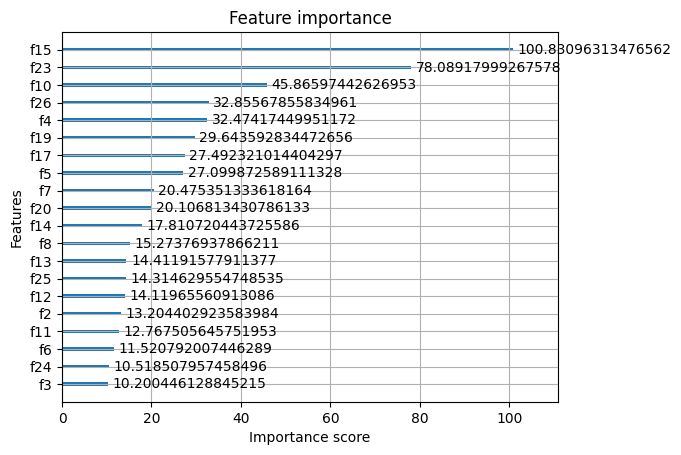

In [34]:
# ==== 8. Avaliação ====
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ==== 9. Importância das features ====
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=20, importance_type="gain")
plt.show()

In [35]:
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Top 20 features mais importantes:")
for i in indices[:20]:
    print(f"{X.columns[i]} -> {importances[i]:.4f}")


Top 20 features mais importantes:
EEG_Pz_Oz_aperiodic_slope_256 -> 0.1656
EEG_Fpz_Cz_beta_relpow_256 -> 0.1282
EEG_Pz_Oz_slow_fast_ratio_256 -> 0.0753
EMG_submental_median_1hz -> 0.0539
EEG_Pz_Oz_beta_relpow_256 -> 0.0533
EOG_delta_relpow_256 -> 0.0487
EOG_rms -> 0.0451
EEG_Pz_Oz_delta_relpow_256 -> 0.0445
EEG_Fpz_Cz_theta_relpow_256 -> 0.0336
EOG_sef95_256 -> 0.0330
EEG_Fpz_Cz_aperiodic_slope_256 -> 0.0292
EEG_Pz_Oz_alpha_relpow_256 -> 0.0251
EEG_Fpz_Cz_alpha_sigma_ratio_256 -> 0.0237
EOG_theta_relpow_256 -> 0.0235
EEG_Pz_Oz_theta_alpha_ratio_256 -> 0.0232
age -> 0.0217
EEG_Fpz_Cz_delta_theta_ratio_256 -> 0.0210
EEG_Fpz_Cz_sigma_relpow_256 -> 0.0189
EEG_Fpz_Cz_alpha_relpow_256 -> 0.0173
tso_min -> 0.0167
